### Data analysis with Tori web scrapping

Tori is a big website for selling second hand stuffs in Finland. In this analysis, I am accessing Tori car selling page to getting the data and conducting a data analysis. The purpose of this analysis is to analyze the car price range based on basic element such as Engine Capacity, Car Manufacture Year, Fuel, etc.

### Data Scrapping

First, I import the working libraries for this analysis

In [43]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from IPython.core.display import HTML
from IPython.display import Image
import seaborn as sns
import plotly.express as px

Accessing Tori and scrapping 40 pages

In [44]:
responses = []
for i in range(40):
    url = f'https://www.tori.fi/koko_suomi/autot?ca=18&cg=2010&w=3&o={i}'
    response = requests.get(url)
    responses.append(response)

In [45]:
items = []
for response in responses:
    parser = BeautifulSoup(response.content, 'html.parser')
    ad_nodes = parser.find_all('a', attrs = {'class': 'item_row_flex'})
    for item in ad_nodes:
        url = item['href']
        price = item.find('p', attrs = {'class': 'list_price ineuros'}).get_text()
        title = item.find('div', attrs = {'class': 'li-title'}).get_text()
        img_node = item.find('div', attrs = {'class': 'item_image_div thumb_extra_image'})
        img = img_node.img['src'] if img_node != None else None
        location = item.find('div', attrs = {'class': 'cat_geo clean_links'}).p.string.strip()

        params = ''
        param_nodes = item.find_all('p', attrs = {'class': 'param'})
        for param in param_nodes[1:]:
            if param['class'] != ['param', 'param-long']:
                params = param.get_text()

        items.append({'Image': img, "Name": title, 'Price': price, 'Param': params, "Location": location 
    #                   "Url": url
                     })
    
ads = pd.DataFrame(items)

In [46]:
tori_data = pd.DataFrame(ads)

def img_func(path):
    return '<img src="'+ path + '" width="60">'

HTML(tori_data.to_html(escape=False,formatters=dict(Image=img_func)))

,Image,Name,Price,Param,Location
0,,"Ford Transit Van 2,2 Tdi",Päivävuokra 70 €/pv,,Pirkanmaa
1,,Volkswagen Passat,13 499 €,2014|93 600 km|1.6 l|Diesel,Pohjois-Pohjanmaa
2,,Mercedes-benz c 220 cdi,6 150 €,2004|218 000 km|Diesel,Pohjois-Pohjanmaa
3,None,Ww passat farkku p -auto,3 750 €,2008|275 000 km|Diesel,Pohjois-Pohjanmaa
4,,Toyota Rav4,6 700 €,2006|301 000 km|2.0 l|Bensiini,Pohjois-Pohjanmaa
5,,Mercedes-Benz S 320 CDI,15 490 €,2007|241 000 km|Diesel,Varsinais-Suomi
6,,"Mercedes-Benz E 220CDI automaatti farmari, vetok",17 900 €,2011|173 000 km|Diesel,Varsinais-Suomi
7,,Mercedes-Benz E 220CDI aut. vetok. Webasto,4 990 €,2005|449 000 km|2.1 l|Diesel,Varsinais-Suomi
8,None,AUDI A3,18 400 €,2015|64 000 km|1.4 l|Bensiini,Uusimaa
9,,Citroen C4 1.4i -05,1 490 €,2005|165 000 km|1.4 l|Bensiini,Satakunta


In [47]:
tori_data.to_csv(f'desktop/data.csv', index= False) #save to csv file for further analysis without making requests again

### Data cleaning

In [2]:
tori_dt = pd.read_csv('data.csv')

In [3]:
tori_dt.reset_index(drop = True)

,Image,Name,Price,Param,Location
0,https://images.tori.fi/api/v1/imagestori/image...,"Kia Cerato 1,5 CRDI",1 800 €,2006|267 000 km|1.5 l|Diesel,Päijät-Häme
1,https://images.tori.fi/api/v1/imagestori/image...,"vw passat-98 kats.15,12,2020",1 200 €,1998|268 500 km|1.6 l|Bensiini,Etelä-Karjala
2,https://images.tori.fi/api/v1/imagestori/image...,Toyota avensis verso,1 290 €,2002|393 000 km|2.0 l|Diesel,Pirkanmaa
3,https://images.tori.fi/api/v1/imagestori/image...,"Audi S6 4.2 V8 Avant Quattro A, katsastettu 16.11",2 550 €,1995|427 000 km|Bensiini,Päijät-Häme
4,https://images.tori.fi/api/v1/imagestori/image...,Toyota Yaris,7 990 €,2013|151 000 km|1.3 l|Bensiini,Satakunta
...,...,...,...,...,...
1595,https://images.tori.fi/api/v1/imagestori/image...,Renault CLIO,12 900 €,2019|13 000 km|0.9 l|Bensiini,Pohjois-Pohjanmaa
1596,https://images.tori.fi/api/v1/imagestori/image...,Audi A6,23 900 €,2014|184 000 km|3.0 l|Diesel,Pohjois-Pohjanmaa
1597,NaN,Skoda Scala,17 980 €(alv.väh.kelp.),2020|24 000 km|1.0 l|Bensiini,Varsinais-Suomi
1598,https://images.tori.fi/api/v1/imagestori/image...,CITROEN C4 CACTUS,14 500 €,2018|46 000 km|1.2 l|Bensiini,Kymenlaakso


In [4]:
tori_dt.pop('Image')

0       https://images.tori.fi/api/v1/imagestori/image...
1       https://images.tori.fi/api/v1/imagestori/image...
2       https://images.tori.fi/api/v1/imagestori/image...
3       https://images.tori.fi/api/v1/imagestori/image...
4       https://images.tori.fi/api/v1/imagestori/image...
                              ...                        
1595    https://images.tori.fi/api/v1/imagestori/image...
1596    https://images.tori.fi/api/v1/imagestori/image...
1597                                                  NaN
1598    https://images.tori.fi/api/v1/imagestori/image...
1599                                                  NaN
Name: Image, Length: 1600, dtype: object

In [6]:
tori_dt.dropna(subset=['Param'], inplace = True)

In [7]:
param = tori_dt['Param'].str.split('|', expand = True)        

In [8]:
mileage_list = []
year_list = []
fuel_list = []
engine_list = []

def is_mileage(v):
    return 'km' in v

def is_year(v):
    try:
        return int(v) > 1900 and int(v) < 2100
    except ValueError:
        return False

def is_engine(v):
    return re.match('\d\.\d\s+[l|L]', v)

def is_fuel(v):
    return v in ['Bensiini', 'Diesel', 'Hybridi', 'Kaasu', 'Sähkö', 'E85 / Flexifuel']
        
def arrange(l):
    year = None
    for v in l:
        if is_year(v):
            year = v
            break
    year_list.append(year)
    mileage = None
    for v in l:
        if is_mileage(v):
            mileage = v
            break
    mileage_list.append(mileage)
    engine = None
    for v in l:
        if is_engine(v):
            engine = v
            break
    engine_list.append(engine)
    fuel = None
    for v in l:
        if is_fuel(v):
            fuel = v
            break
    fuel_list.append(fuel)          

for i in range(0, len(param)):
    l = list(param.iloc[i,:])
    arrange([v for v in l if v != None])


In [9]:
tori_dt['Year'] = year_list
tori_dt['Mileage'] = mileage_list
tori_dt['Engine'] = engine_list
tori_dt['Fuel'] = fuel_list

In [11]:
tori_dt.isnull().sum()

Name          0
Price        14
Param         0
Location      0
Year         25
Mileage      61
Engine      163
Fuel         28
dtype: int64

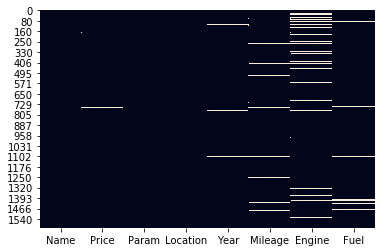

In [12]:
sns.heatmap(tori_dt.isnull(), cbar = False)

In [13]:
tori_dt.pop('Param')

0         2006|267 000 km|1.5 l|Diesel
1       1998|268 500 km|1.6 l|Bensiini
2         2002|393 000 km|2.0 l|Diesel
3             1995|427 000 km|Bensiini
4       2013|151 000 km|1.3 l|Bensiini
                     ...              
1595     2019|13 000 km|0.9 l|Bensiini
1596      2014|184 000 km|3.0 l|Diesel
1597     2020|24 000 km|1.0 l|Bensiini
1598     2018|46 000 km|1.2 l|Bensiini
1599       2018|63 000 km|2.0 l|Diesel
Name: Param, Length: 1460, dtype: object

In [14]:
tori_dt.reset_index(drop=True)

,Name,Price,Location,Year,Mileage,Engine,Fuel
0,"Kia Cerato 1,5 CRDI",1 800 €,Päijät-Häme,2006,267 000 km,1.5 l,Diesel
1,"vw passat-98 kats.15,12,2020",1 200 €,Etelä-Karjala,1998,268 500 km,1.6 l,Bensiini
2,Toyota avensis verso,1 290 €,Pirkanmaa,2002,393 000 km,2.0 l,Diesel
3,"Audi S6 4.2 V8 Avant Quattro A, katsastettu 16.11",2 550 €,Päijät-Häme,1995,427 000 km,None,Bensiini
4,Toyota Yaris,7 990 €,Satakunta,2013,151 000 km,1.3 l,Bensiini
...,...,...,...,...,...,...,...
1455,Renault CLIO,12 900 €,Pohjois-Pohjanmaa,2019,13 000 km,0.9 l,Bensiini
1456,Audi A6,23 900 €,Pohjois-Pohjanmaa,2014,184 000 km,3.0 l,Diesel
1457,Skoda Scala,17 980 €(alv.väh.kelp.),Varsinais-Suomi,2020,24 000 km,1.0 l,Bensiini
1458,CITROEN C4 CACTUS,14 500 €,Kymenlaakso,2018,46 000 km,1.2 l,Bensiini


In [15]:
data = tori_dt.dropna()
data.reset_index(drop = True, inplace = True)
#data.Price.unique()

In [16]:
data.Price = data.Price.str.extract(r'([0-9 ]+)')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Data Analysis

#### Regions

In [17]:
tori_dt.Location.unique()

array(['Päijät-Häme', 'Etelä-Karjala', 'Pirkanmaa', 'Satakunta',
       'Pohjois-Pohjanmaa', 'Uusimaa', 'Lappi', 'Pohjois-Karjala',
       'Pohjois-Savo', 'Etelä-Pohjanmaa', 'Varsinais-Suomi',
       'Keski-Suomi', 'Kanta-Häme', 'Pohjanmaa', 'Kainuu', 'Etelä-Savo',
       'Keski-Pohjanmaa', 'Kymenlaakso'], dtype=object)

In [18]:
location = tori_dt.groupby('Location').count()
location.reset_index(inplace = True)

In [1]:
px.pie(location, values = 'Name', names = 'Location',
       title = 'Number of cars in each regions')

NameError: name 'px' is not defined